# 准备数据集

In [1]:
import torch,torchvision
import torchvision.transforms as transforms
from torch import nn
from torch import optim
import numpy as np
print(torch.__version__)

1.0.0


In [2]:
batch_size = 256
num_workers = 4

In [3]:
mnist_train = torchvision.datasets.FashionMNIST(root="./FashionMNIST2065", 
                                                train=True, 
                                                download=True, 
                                                transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root="./FashionMNIST2065", 
                                               train=False, 
                                               download=True, 
                                               transform=transforms.ToTensor())

In [4]:
train_iter_torch = torch.utils.data.DataLoader(mnist_train, 
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True)
test_iter_torch = torch.utils.data.DataLoader(mnist_test, 
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True)

# 从零开始创建多层感知机

## 定义模型参数

In [5]:
num_inputs, num_outputs, num_hiddens = 28*28, 10, 256

In [6]:
W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_outputs)), dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

In [7]:
W1.requires_grad_(requires_grad=True)
b1.requires_grad_(requires_grad=True)
W2.requires_grad_(requires_grad=True)
b2.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [8]:
W1.shape.numel(),b1.shape.numel(),W2.shape.numel(),b2.shape.numel()

(200704, 256, 2560, 10)

In [9]:
num_inputs*num_hiddens, num_hiddens, num_hiddens*num_outputs, num_outputs

(200704, 256, 2560, 10)

## 定义模型

多层感知机需要激活函数增加非线性

- ReLu函数是一个通用的激活函数，目前在大多数情况下使用。但是，ReLU函数只能在隐藏层中使用。
- 用于分类器时，sigmoid函数及其组合通常效果更好。由于梯度消失问题，有时要避免使用sigmoid和tanh函数。
- 在神经网络层数较多的时候，最好使用ReLu函数，ReLu函数比较简单计算量少，而sigmoid和tanh函数计算量大很多。

在选择激活函数的时候可以先选用ReLu函数如果效果不理想可以尝试其他激活函数。

**ReLu在x为负时，梯度也为0，不算梯度消失吗？**

In [10]:
import matplotlib.pyplot as plt

In [11]:
a = torch.arange(-8.0, 8.0, 0.1)

### relu

In [12]:
def relu(X):
    return torch.max(X, other=torch.tensor(0.0))

In [13]:
b = relu(a)

Text(0.5, 1.0, 'relu')

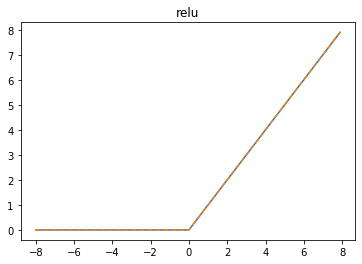

In [14]:
plt.plot(a.detach().numpy(),b.detach().numpy())
plt.plot(a.detach().numpy(),a.relu().detach().numpy(),"--")
plt.title("relu")

### sigmoid
$$\text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$
$$\text{sigmoid}'(x) = \text{sigmoid}(x)\left(1-\text{sigmoid}(x)\right).$$

In [15]:
def sigmoid(X):
    return 1/(1+torch.exp(-X))

In [16]:
b = sigmoid(a)

Text(0.5, 1.0, 'sigmoid')

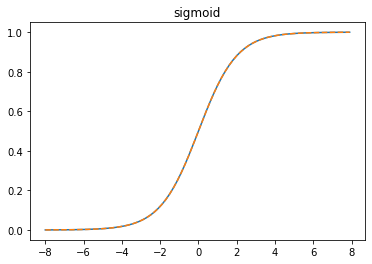

In [17]:
plt.plot(a.detach().numpy(),b.detach().numpy())
plt.plot(a.detach().numpy(),a.sigmoid().detach().numpy(), "--")
plt.title("sigmoid")

### tanh
$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$
$$\text{tanh}'(x) = 1 - \text{tanh}^2(x).$$

In [18]:
def tanh(X):
    return (1-torch.exp(-2*X))/(1+torch.exp(-2*X))

In [19]:
b = tanh(a)

Text(0.5, 1.0, 'tanh')

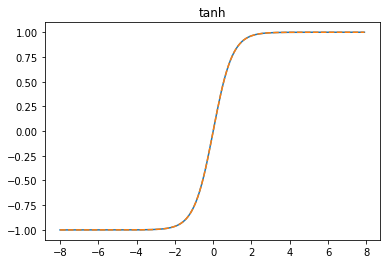

In [20]:
plt.plot(a.detach().numpy(),b.detach().numpy())
plt.plot(a.detach().numpy(),a.tanh().detach().numpy(), "--")
plt.title("tanh")

### 定义网络

- torch.matmul
- torch.mm

In [21]:
def net(X):
    X = X.view((-1,num_inputs))
    H = relu(torch.matmul(X,W1)+b1)
    return torch.matmul(H,W2)+b2

In [22]:
for X, y in train_iter_torch:
    break

In [34]:
X = X.view((-1,num_inputs))
H = relu(torch.matmul(X,W1)+b1)
y_hat = torch.matmul(H,W2)+b2
y_hat.shape

torch.Size([256, 10])

## 定义损失函数

In [32]:
loss = torch.nn.CrossEntropyLoss()

In [36]:
loss(y_hat, y).sum()

tensor(2.3044, grad_fn=<SumBackward0>)

### 定义指标

In [37]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n

In [38]:
evaluate_accuracy(test_iter_torch, net)

0.0705

## 定义优化函数

In [42]:
optimizer = optim.SGD([W1,b1,W2,b2],lr=0.5)

## 训练模型
1. 梯度清零
2. 计算模型输出
3. 计算当前损失
4. 梯度反向传播
5. 优化器不近


In [43]:
num_epochs, lr = 5, 0.5

In [45]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
           
            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到
            
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

In [46]:
train_ch3(net, train_iter_torch, test_iter_torch, loss, num_epochs, batch_size, [W1,b1,W2,b2], lr, optimizer)

epoch 1, loss 0.0032, train acc 0.689, test acc 0.766
epoch 2, loss 0.0019, train acc 0.819, test acc 0.810
epoch 3, loss 0.0016, train acc 0.845, test acc 0.816
epoch 4, loss 0.0015, train acc 0.856, test acc 0.835
epoch 5, loss 0.0015, train acc 0.864, test acc 0.848


In [50]:
for epoch in range(1, num_epochs+1):
    train_l_sum, train_acc_sum,n = 0.0,0.0,0
    for X, y in train_iter_torch:
        y_hat = net(X)
        W1.grad.data.zero_()
        b1.grad.data.zero_()
        W2.grad.data.zero_()
        b2.grad.data.zero_()
        l = loss(y_hat,y).sum()
        l.backward()
        optimizer.step()
        
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter_torch,net)
    print("epoch {:d}, train_loss {:.4f}, train_acc_sum {:.4f}, test_acc {:.4f}".format(epoch,train_l_sum/n,train_acc_sum/n,test_acc))

epoch 1, train_loss 0.0014, train_acc_sum 0.8693, test_acc 0.8591
epoch 2, train_loss 0.0013, train_acc_sum 0.8758, test_acc 0.8529
epoch 3, train_loss 0.0013, train_acc_sum 0.8800, test_acc 0.8574
epoch 4, train_loss 0.0012, train_acc_sum 0.8821, test_acc 0.8482
epoch 5, train_loss 0.0012, train_acc_sum 0.8858, test_acc 0.8653


## 检查结果

In [47]:
def get_fashion_mnist_labels(ilabels):
    text_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    return [text_labels[int(i)] for i in ilabels]

In [48]:
def show_fashion_mnist(images, labels):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(8,4))
    for ax, img, lbl in zip(axes.flatten(), images, labels):
        ax.imshow(img.view(28,28).numpy())
        ax.set_title(lbl)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    plt.tight_layout()

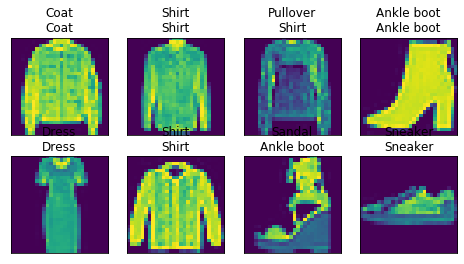

<Figure size 432x288 with 0 Axes>

In [49]:
X, y = iter(test_iter_torch).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [tr+"\n"+pred for tr,pred in zip(true_labels,pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

# 多层感知机的简洁实现

In [60]:
from torch.nn import init

## 定义模型

In [54]:
num_inputs, num_outputs, num_hiddens

(784, 10, 256)

In [55]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer,self).__init__()
    
    def forward(self,x):
        return x.view(x.shape[0],-1)

In [90]:
net2 = nn.Sequential()
net2.add_module("flat", FlattenLayer())
net2.add_module("linear1", nn.Linear(num_inputs, num_hiddens))
net2.add_module("relu", nn.ReLU())
net2.add_module("linear2",nn.Linear(num_hiddens, num_outputs))

## 模型参数初始化

In [92]:
for params in net2.parameters():
    init.normal_(params, mean=0, std=0.01)

## 定义损失函数

In [93]:
loss = torch.nn.CrossEntropyLoss()

## 定义优化函数

In [94]:
optimizer2 = optim.SGD(net2.parameters(),lr=0.5)

## 训练模型

In [95]:
train_ch3(net2, train_iter_torch, test_iter_torch, loss, num_epochs, batch_size, None, None, optimizer2)

epoch 1, loss 0.0031, train acc 0.699, test acc 0.746
epoch 2, loss 0.0019, train acc 0.819, test acc 0.814
epoch 3, loss 0.0016, train acc 0.846, test acc 0.830
epoch 4, loss 0.0015, train acc 0.856, test acc 0.826
epoch 5, loss 0.0014, train acc 0.865, test acc 0.843


In [96]:
for epoch in range(1, num_epochs+1):
    train_l_sum, train_acc_sum,n = 0.0,0.0,0
    for X, y in train_iter_torch:
        y_hat = net2(X)
        l = loss(y_hat,y).sum()
        optimizer2.zero_grad()
        l.backward()
        optimizer2.step()
        
        train_l_sum += l.item()
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter_torch,net2)
    print("epoch {:d}, train_loss {:.4f}, train_acc_sum {:.4f}, test_acc {:.4f}".format(epoch,train_l_sum/n,train_acc_sum/n,test_acc))

epoch 1, train_loss 0.0014, train_acc_sum 0.8702, test_acc 0.8328
epoch 2, train_loss 0.0013, train_acc_sum 0.8763, test_acc 0.8284
epoch 3, train_loss 0.0013, train_acc_sum 0.8816, test_acc 0.8456
epoch 4, train_loss 0.0012, train_acc_sum 0.8865, test_acc 0.8597
epoch 5, train_loss 0.0012, train_acc_sum 0.8877, test_acc 0.8430
